In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import statistics
import random
import math

In [2]:
#bit length of secret target intermediate value
mv = 4
#code length
nc = 8
#remove the first part of the measurements -- initial part has more noise and correspond to NOPs
cut_off = 200

In [3]:
#compute Hamming weight of an integer a
def HW_fun(a):
    abin = format(a,'b').zfill(nc)#binary representation of v
    abin_array = [int(abin[i]) for i in range(nc)]
    hw = 0
    for i in range(nc):
        if abin_array[i] == 1:
            hw = hw+1
    return hw

In [4]:
#Generate integers with bit length bit_length and Hamming weight hw
def generate_integers(bit_length, hw):
    words = []
    total_number = 2**bit_length #total number of integers wtih bit length bit_length
    for a in range(total_number):
        if HW_fun(a) == hw:
            words.append(a)
    return words

In [5]:
#save data to file for tikz plot
def savetofile(filename,array, start):
    f = open(filename+".txt", "w")
    f.write("x y\n")
    i = 0
    for i in range(start,len(array)):
        f.write(str(i-start)+" "+str(array[i])+"\n")
        i+=1
    f.close()
#find the three points with the highest value given the array
def highest_tree_points(array,cut_off):
    array_abs = [abs(a) for a in array]
    ind = np.argpartition(array_abs, -3)[-3:]
    for index in ind:
        print(str(index-cut_off))
    array_abs = np.array(array_abs)
    print(array_abs[ind])
    return

In [6]:
#Load data from dataset for MOV instruction with four bits
file_no_mov = 10000

traces_mov = []
bytes_mov = []

for i in range(file_no_mov):
    with open('MOV_SNR_traces/trace_'+str(i)+'.txt') as f:
        lines = f.read().splitlines()
        traces_mov.append(lines)

with open('MOV_SNR_traces/bytes.txt') as f:
    bytes_mov = f.read().splitlines()
    
traces_array_mov = np.array(traces_mov)
traces_array_mov = traces_array_mov.astype(float)
for i in range(file_no_mov):
    bytes_mov[i] = int(bytes_mov[i],16)
bytes_array_mov = np.array(bytes_mov)

In [7]:
#Load data from dataset for MOV instruction with longer bits
file_no_long = 10000

traces_long = []
bytes_long = []

for i in range(file_no_long):
    with open('MOV_profile_traces/trace_'+str(i)+'.txt') as f:
        lines = f.read().splitlines()
        traces_long.append(lines)

with open('MOV_profile_traces/bytes_long_bit.txt') as f:
    bytes_long = f.read().splitlines()
    
traces_array_long = np.array(traces_long)
traces_array_long = traces_array_long.astype(float)
for i in range(file_no_long):
    bytes_long[i] = int(bytes_long[i],16)

In [8]:
q = len(traces_array_mov[0]) #number of time samples
print(q)

800


In [9]:
def computeSNR(t, if_print, no_of_traces, traces, inputs, bit_length):  
    #no_of_sets sets is 2^(bit_length), signal is given by the exact value of the input
    no_of_sets = 2**bit_length
   
    A = [[] for y in range(no_of_sets)] 
    
    #for each trace/byte
    for j in range(no_of_traces):
        v = inputs[j]#value of the target intermediate value
        A[v].append(traces[j][t])#group the leakage at time t according to this output
    
    #compute the averages for leakages in each set
    avg = []
    for v in range(no_of_sets):
        avg.append(statistics.mean(A[v]))
        if if_print:
            print("average of A[" + str(v) + "] is %s" %(statistics.mean(A[v])))
    
    #variance of signal is given by the variance of leakage avgs
    varX = np.var(avg)
    
    #take leakage minus mean
    LminusAvg = []
    for v in range(no_of_sets):
        for j in range(len(A[v])):
            LminusAvg.append(A[v][j]-avg[v])
    #variance of noise is given by variance of leakage minus mean
    varN = np.var(LminusAvg)
    
    #SNR is given by variance of signal divided by variance of noise
    snr = varX/varN
    if if_print:
        print("\nVariance of the signal is % s " %(varX))
        print("Variance of the noise is % s " %(varN))
        print("SNR is % s " %(snr))
    return varX, varN, snr

In [10]:
computeSNR(1, 0, file_no_mov, traces_array_mov, bytes_mov, mv)

(1.7664795125084388e-09, 1.1541446140777044e-06, 0.0015305530095291058)

In [11]:
def SNR_for_all(no_of_traces, traces, inputs, bit_length):
    varX = [0 for i in range(q)]
    varN = [0 for i in range(q)]
    SNR = [0 for i in range(q)]
    for t in range(q):
        varX[t], varN[t],SNR[t]=computeSNR(t,0,no_of_traces, traces, inputs, bit_length)
    plt.figure(figsize=(10,6))    
    ax1 = plt.subplot(3, 1, 1)
    plt.plot(varX)
    ax2 = plt.subplot(3, 1, 2)
    plt.plot(varN)
    ax3 = plt.subplot(3, 1, 3)
    plt.plot(SNR)
    ax1.set_title("Signal")
    ax2.set_title("Noise")
    ax3.set_title("SNR")
    
    plt.tight_layout()

    return SNR

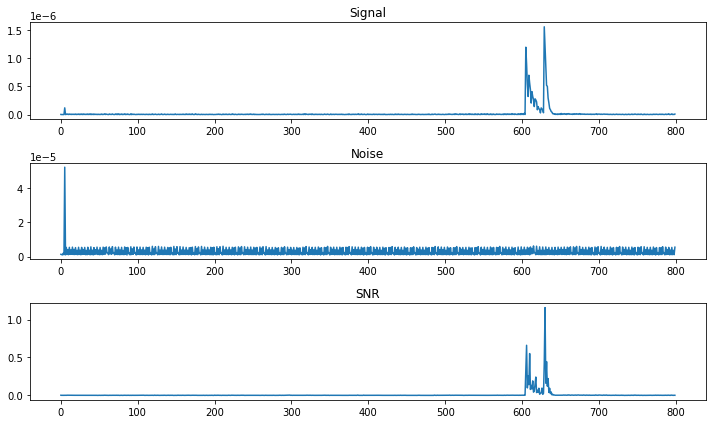

In [12]:
#SNR for four bit inputs
SNR_four = SNR_for_all(file_no_mov, traces_array_mov, bytes_mov, mv)

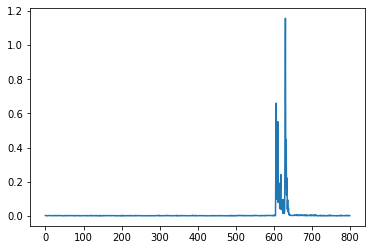

In [13]:
plt.plot(SNR_four)
#save SNR values to file
savetofile("SCA_countermeasure/SNR", SNR_four, cut_off)
#save one trace to file
savetofile("SCA_countermeasure/one_trace", traces_array_mov[0], cut_off)

In [14]:
#POI using traces with 4-bit values
highest_tree_points(SNR_four,cut_off)

410
406
430
[0.55197401 0.66085097 1.15756459]


## Profile coefficients for stochatic leakage model

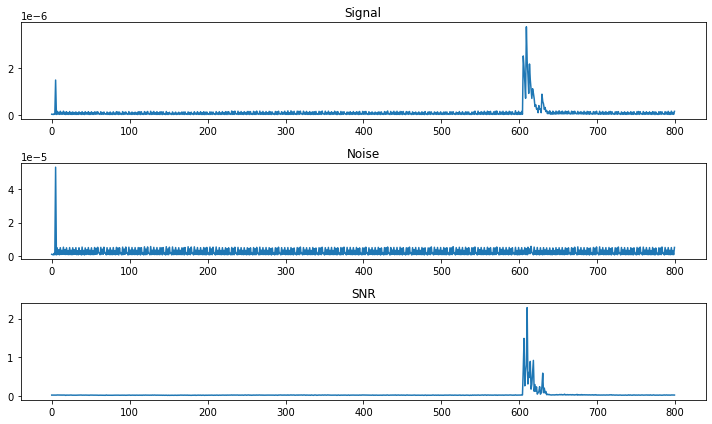

In [15]:
#SNR for long inputs
SNR_long = SNR_for_all(file_no_long, traces_array_long, bytes_long, nc)
#save SNR values to file
savetofile("SCA_countermeasure/SNR_long", SNR_long, cut_off)
#save one profile trace to file
savetofile("SCA_countermeasure/one_trace_profile", traces_array_long[0], cut_off)

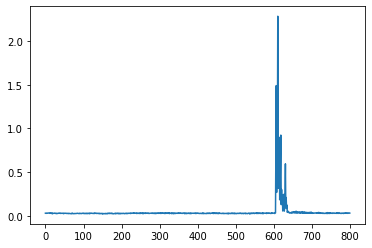

In [16]:
plt.plot(SNR_long)

In [97]:
#profile the coefficients for the stochastic leakage model using traces from MOV_profile_traces
##no_of_traces: number of traces to use for profiling
##POI: poi for profiling
def stochastic_LM(POI, ifprint, hw):
    leakages = traces_array_long[:,POI]
    M = np.zeros((file_no_long, nc))#size of matrix M is no_of_traces*(bit length of codeword)
    for j in range(file_no_long):
        v = bytes_long[j] #intermediate value
        vbin = format(v,'b').zfill(nc)#binary representation of v
        vbin_array = [int(vbin[i]) for i in range(nc)]
        for i in range(nc):
            M[j][i]=vbin_array[nc-1-i]
    if ifprint:
        print("first row of M:")
        print(M[0])
        print("first input:" + str(bytes_long[0]))
    MT = np.transpose(M)
    A = np.linalg.inv(np.matmul(MT,M))
    alpha = np.matmul(A,MT)
    alpha = np.dot(alpha,leakages)
    print(alpha)
    
    if ifprint:
        print("signals according to stochastic leakage model")
    slM = []
    words = generate_integers(nc,hw)
    for v in range(2**nc):
        vbin = format(v,'b').zfill(nc)#binary representation of v
        vbin_array = [int(vbin[i]) for i in range(nc)]
        sleakage = 0
        for i in range(nc):
            sleakage += alpha[i]*vbin_array[nc-1-i]
        slM.append(sleakage)
        if v in words:
            if ifprint:
                print("\\texttt{{{:X}}} & ".format(v) + ''.join(str(x) for x in vbin_array) + " & $%.5f$\\\\" %sleakage)
    return slM

In [98]:
slm = stochastic_LM(430+cut_off,1, 6)

first row of M:
[0. 1. 1. 0. 1. 1. 1. 0.]
first input:118
[-0.00245761 -0.00130026 -0.00135884 -0.00122801 -0.00131569 -0.00213467
 -0.00209748 -0.00221288]
signals according to stochastic leakage model
\texttt{3F} & 00111111 & $-0.00980$\\
\texttt{5F} & 01011111 & $-0.00976$\\
\texttt{6F} & 01101111 & $-0.01058$\\
\texttt{77} & 01110111 & $-0.01066$\\
\texttt{7B} & 01111011 & $-0.01053$\\
\texttt{7D} & 01111101 & $-0.01059$\\
\texttt{7E} & 01111110 & $-0.00943$\\
\texttt{9F} & 10011111 & $-0.00987$\\
\texttt{AF} & 10101111 & $-0.01069$\\
\texttt{B7} & 10110111 & $-0.01078$\\
\texttt{BB} & 10111011 & $-0.01065$\\
\texttt{BD} & 10111101 & $-0.01071$\\
\texttt{BE} & 10111110 & $-0.00955$\\
\texttt{CF} & 11001111 & $-0.01066$\\
\texttt{D7} & 11010111 & $-0.01074$\\
\texttt{DB} & 11011011 & $-0.01061$\\
\texttt{DD} & 11011101 & $-0.01067$\\
\texttt{DE} & 11011110 & $-0.00951$\\
\texttt{E7} & 11100111 & $-0.01156$\\
\texttt{EB} & 11101011 & $-0.01143$\\
\texttt{ED} & 11101101 & $-0.01149$\\

## Find the optimal code

In [117]:
def get_code(hw, ifprint):
    code_size = 2**mv
    #T is the table of signals for each integer between 0 and 2^{nC}-1
    T=np.array(slm)
    total_words = 2**nc
    if hw != 0:
        words = generate_integers(nc,hw)
#         print("All codes with HW" + str(hw))
#         print(words)
        total_words = len(words)
        T = T[words]
        print ('hex: [{}]'.format(', '.join(hex(x)[2:] for x in words)))
    #sort the array in ascending order, Tsorted[0] continas the lowest value from T
    T_sorted = np.sort(T) 
    
    
    #I records the corresponding word in $\FF_2^{2^{n_C}}$ for each signal in Tsorted
    I = np.argsort(T)
    if hw != 0:
        for i in range(total_words):
            I[i] = words[I[i]]
            
    D=[]
    #the jth entry of D is given by the difference between the value in 
    #Tsorted[j+2^{m_v}] and T[j]
    for j in range(total_words-code_size+1):
        D.append(T_sorted[j+code_size-1]-T_sorted[j])
    #ind is the index of the smallest value in D
    ind = D.index(min(D))
    #the code consists of codewords that correspond to signals in the interval 
    #D[ind] and D[ind+code_size-1]
    C = []
    for j in range(code_size):
        C.append(I[ind+j])
    print(C)
    print ('hex: [{}]'.format(', '.join(hex(x)[2:] for x in C)))
    print ('binary: [{}]'.format(', '.join(bin(x)[2:] for x in C)))
    
    if ifprint:
        for i in range(total_words):
            v = I[i]
            vbin = format(v,'b').zfill(nc)#binary representation of v
            if v in C:
                print("\\textcolor{{blue}}{{\\texttt{{{:X}}}}} & \\textcolor{{blue}}{{".format(I[i]) + vbin + "} & $%.5f$\\\\" %T_sorted[i])
            else:
                print("\\texttt{{{:X}}} & ".format(I[i]) + vbin + " & $%.5f$\\\\" %T_sorted[i])
    return C

In [6]:
total_different_hw = 7
def get_all_code():
    C = [[] for i in range(total_different_hw)]
    print("The optimal code among all")
    C[0] = get_code(0,0)
    for hw in range(2,7):
        print("\nThe optimal code with Hamming weight " + str(hw))
        if hw == 6: #print the sorted codes for hw =6
            C[hw] = get_code(hw,1)
        else:
            C[hw] = get_code(hw,0)
    return C

In [119]:
C = get_all_code()

The optimal code among all
[86, 154, 60, 133, 46, 92, 145, 78, 58, 131, 37, 90, 69, 49, 137, 35]
hex: [56, 9a, 3c, 85, 2e, 5c, 91, 4e, 3a, 83, 25, 5a, 45, 31, 89, 23]
binary: [1010110, 10011010, 111100, 10000101, 101110, 1011100, 10010001, 1001110, 111010, 10000011, 100101, 1011010, 1000101, 110001, 10001001, 100011]

The optimal code with Hamming weight 2
hex: [3, 5, 6, 9, a, c, 11, 12, 14, 18, 21, 22, 24, 28, 30, 41, 42, 44, 48, 50, 60, 81, 82, 84, 88, 90, a0, c0]
[5, 17, 3, 9, 132, 144, 130, 36, 68, 48, 136, 34, 80, 66, 40, 72]
hex: [5, 11, 3, 9, 84, 90, 82, 24, 44, 30, 88, 22, 50, 42, 28, 48]
binary: [101, 10001, 11, 1001, 10000100, 10010000, 10000010, 100100, 1000100, 110000, 10001000, 100010, 1010000, 1000010, 101000, 1001000]

The optimal code with Hamming weight 3
hex: [7, b, d, e, 13, 15, 16, 19, 1a, 1c, 23, 25, 26, 29, 2a, 2c, 31, 32, 34, 38, 43, 45, 46, 49, 4a, 4c, 51, 52, 54, 58, 61, 62, 64, 68, 70, 83, 85, 86, 89, 8a, 8c, 91, 92, 94, 98, a1, a2, a4, a8, b0, c1, c2, c4, c8,

In [38]:
print(C)

[[86, 154, 60, 133, 46, 92, 145, 78, 58, 131, 37, 90, 69, 49, 137, 35], [], [5, 17, 3, 9, 132, 144, 130, 36, 68, 48, 136, 34, 80, 66, 40, 72], [146, 52, 140, 38, 84, 152, 70, 50, 138, 44, 82, 76, 56, 42, 88, 74], [180, 166, 212, 198, 178, 172, 210, 116, 204, 184, 102, 170, 216, 114, 202, 108], [181, 167, 213, 199, 179, 173, 211, 117, 205, 185, 103, 171, 217, 115, 203, 109], [183, 215, 189, 175, 221, 119, 207, 187, 219, 125, 111, 123, 246, 252, 238, 250]]


In [53]:
def signal_for_code():
    var_code = [0 for i in range(total_different_hw)]
    hw = 0
    for code in C:
        if len(code) == 0:
            hw = hw + 1
            continue
        AC = []
        for index in range(2**mv):
            AC.append(slm[code[index]])
        var_code[hw] = statistics.variance(AC)
        hw = hw + 1
    return var_code
var_code = signal_for_code()
print(var_code)

[3.2332384677665804e-09, 0, 2.334950308345351e-08, 3.790064902631628e-09, 3.790064902631626e-09, 3.790064902631627e-09, 2.3349503083453383e-08]


## SNR encoded computation

In [8]:
C = [[86, 154, 60, 133, 46, 92, 145, 78, 58, 131, 37, 90, 69, 49, 137, 35], [], [5, 17, 3, 9, 132, 144, 130, 36, 68, 48, 136, 34, 80, 66, 40, 72], [146, 52, 140, 38, 84, 152, 70, 50, 138, 44, 82, 76, 56, 42, 88, 74], [180, 166, 212, 198, 178, 172, 210, 116, 204, 184, 102, 170, 216, 114, 202, 108], [181, 167, 213, 199, 179, 173, 211, 117, 205, 185, 103, 171, 217, 115, 203, 109], [183, 215, 189, 175, 221, 119, 207, 187, 219, 125, 111, 123, 246, 252, 238, 250]]

In [7]:
#Load data from dataset for MOV instruction with encoding countermeasure
file_no_encoded = 10000

traces_array_encoded = [[] for j in range(total_different_hw)]
bytes_encoded = []

for hw in range(total_different_hw):
    if hw == 1:
        continue
    for i in range(file_no_encoded):
        with open('MOV_protected_traces/hw' + str(hw) + '/trace_' + str(i) +'.txt') as f:
            lines = f.read().splitlines()
            traces_array_encoded[hw].append(lines)
    print("loaded " + str(hw))
    traces_array_encoded[hw] = np.array(traces_array_encoded[hw])
    traces_array_encoded[hw] = traces_array_encoded[hw].astype(np.float)
with open('MOV_protected_traces/hw0/bytes_encoded.txt') as f:
    bytes_encoded = f.read().splitlines()
    

for i in range(file_no_encoded):
    bytes_encoded[i] = int(bytes_encoded[i],16)
bytes_encoded = np.array(bytes_encoded)

q = len(traces_array_encoded[0][0]) #number of time samples
print(q)

loaded 0
loaded 2
loaded 3
loaded 4
loaded 5
loaded 6
800


In [11]:
#SNR for encoded inputs with different codes
def SNR_with_codes():
    SNR_encoded = [0 for j in range(total_different_hw)]
    for hw in range(total_different_hw):
        if hw == 1:
            continue
        SNR_encoded[hw] = SNR_for_all(file_no_encoded, traces_array_encoded[hw], bytes_encoded, mv)
    for hw in range(total_different_hw):
        if hw == 1:
            continue
        plt.plot(SNR_encoded[hw], label=str(hw))
        #save SNR values to file
        savetofile("SCA_countermeasure/SNR_encoded" + str(hw), SNR_encoded[hw], cut_off)
    return SNR_encoded

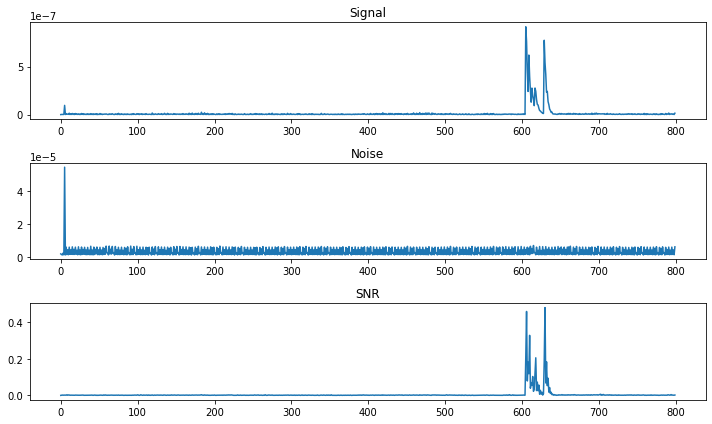

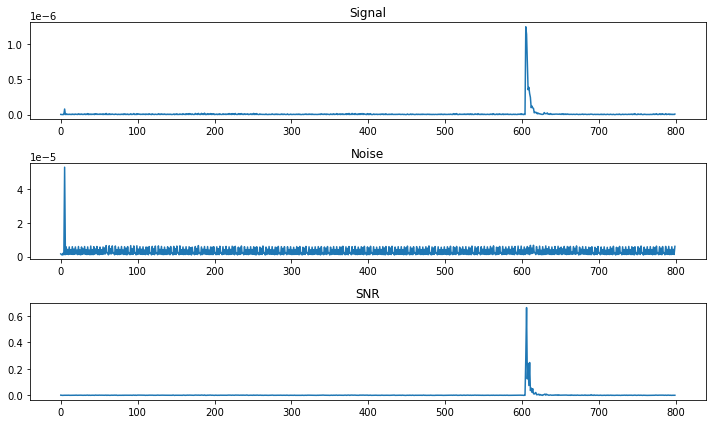

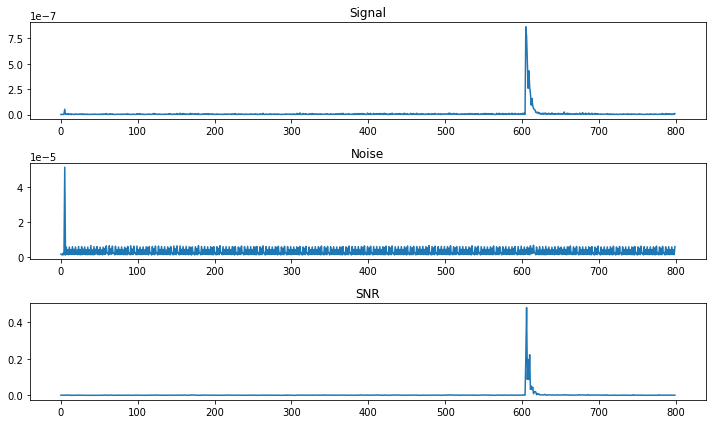

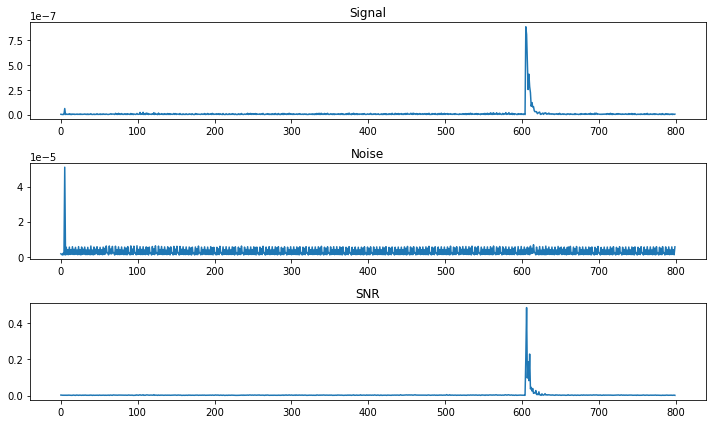

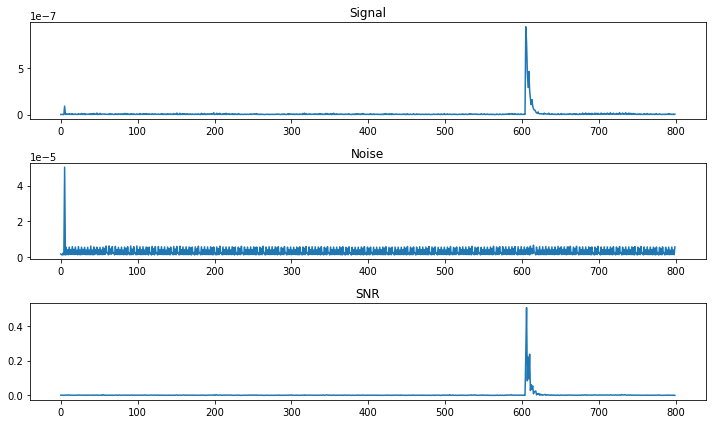

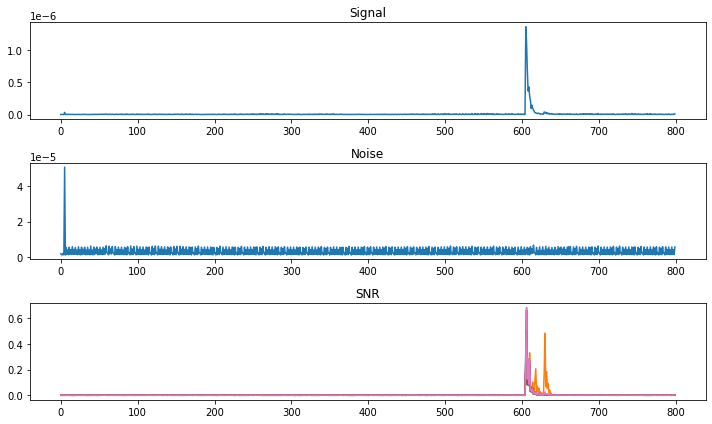

In [56]:
SNR_encoded = SNR_with_codes()

## Build Templates

In [9]:
correct_key = 9
# Hamming weights of numbers 0-63
HW = [0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4, 
      1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 
      1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 
      2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6]

# PRESENT Sbox
S = [12,5,6,11,9,0,10,13,3,14,15,8,4,7,1,2]

cut_off = 200

In [10]:
POI = 430 + cut_off

In [11]:
C = [[86, 154, 60, 133, 46, 92, 145, 78, 58, 131, 37, 90, 69, 49, 137, 35], [], [5, 17, 3, 9, 132, 144, 130, 36, 68, 48, 136, 34, 80, 66, 40, 72], [146, 52, 140, 38, 84, 152, 70, 50, 138, 44, 82, 76, 56, 42, 88, 74], [180, 166, 212, 198, 178, 172, 210, 116, 204, 184, 102, 170, 216, 114, 202, 108], [181, 167, 213, 199, 179, 173, 211, 117, 205, 185, 103, 171, 217, 115, 203, 109], [183, 215, 189, 175, 221, 119, 207, 187, 219, 125, 111, 123, 246, 252, 238, 250]]

In [12]:
#build template on POI
def build_template(leakage_model, no_of_traces, inputs, traces):
    
    if leakage_model == 0:
        no_of_sets = 16 #for signal = identity, we group leakages into 16 sets
    elif leakage_model == 1:
        no_of_sets = 5 #for signal = hamming weight, we group leakages into 5 sets
        
    #record leakages at the POI for traces in each set
    poi_leakage = [[] for x in range(no_of_sets)] 
    #separate leakages to sets depending on the Sbox output value and leakage model
    for j in range(no_of_traces): #for each value
        iv = inputs[j] #the target intermediate value
        if leakage_model == 1:
            iv = HW[iv]
        poi_leakage[iv].append(traces[j,POI])
    
    #mean vectors
    mean_vector = []
    #variances
    variances = []
    for i in range(no_of_sets):
        mean_vector.append(statistics.mean(poi_leakage[i]))
        variances.append(statistics.variance(poi_leakage[i]))
    
    #return mean vector and the covariance matrix
    return mean_vector,variances

In [15]:
##templates for 4 bit inputs, identity leakage model
mean_four, variances_four = build_template(0, file_no_mov, bytes_array_mov, traces_array_mov)
print(mean_four)
print(variances_four)

[-0.010546242920711974, -0.009425586942538594, -0.006801814683860233, -0.007723589085820896, -0.006981878477742448, -0.007784893992932862, -0.006560954147640792, -0.007484447900466563, -0.00676639899380805, -0.007637893097310127, -0.006406679258241758, -0.00732269287109375, -0.00648602911237785, -0.007317254358161648, -0.0061911258971291865, -0.007159846844059406]
[1.179526251912424e-06, 1.0852807312394868e-06, 1.0590016412126708e-06, 1.1082668741461642e-06, 1.1267211106877766e-06, 9.512229568012407e-07, 1.0916476623736817e-06, 1.0271163364315276e-06, 1.0183237625895867e-06, 1.0500934892160947e-06, 9.730523141271317e-07, 1.002922770749422e-06, 1.02550736599448e-06, 1.125816932681869e-06, 9.059009435083293e-07, 9.652314038998893e-07]


In [16]:
##templates for 4 bit inputs, hw leakage model
mean_hw, variances_hw = build_template(1, file_no_mov, bytes_array_mov, traces_array_mov)
print(mean_hw)
print(variances_hw)

[-0.010546242920711974, -0.0074606356750711676, -0.007092750678628178, -0.007083056621408894, -0.007159846844059406]
[1.179526251912424e-06, 2.2777863748128932e-06, 1.4151931009732563e-06, 1.279684075277621e-06, 9.652314038998893e-07]


In [13]:
##templates for encoded inputs, identity leakage model
def get_template_for_encoded():
    mean_encoded = [[] for hw in range(total_different_hw)]
    variances_encoded = [[] for hw in range(total_different_hw)]
    for hw in range(total_different_hw):
        if hw == 1:
            continue
        mean, variances = build_template(0, file_no_encoded, bytes_encoded, traces_array_encoded[hw])
        mean_encoded[hw] = mean
        variances_encoded[hw] = variances
    return mean_encoded, variances_encoded
mean_encoded, variances_encoded = get_template_for_encoded()

In [18]:
print(mean_encoded[6])
print(np.var(mean_encoded[6]))

[-0.010635400158478605, -0.010541945977917981, -0.010363222947761194, -0.010371440831987076, -0.010323194908180301, -0.010580948208722742, -0.010383642814009662, -0.010310832307060756, -0.010232744783306581, -0.010265003551136364, -0.010358647969242902, -0.010335950244698206, -0.0102051580400982, -0.010080989177067083, -0.010138973482008996, -0.009981787186028258]
2.8458962896934257e-08


In [18]:
#Load data from dataset for MOV instruction, attack traces, original inputs
file_no_original = 100000

traces_original = []
plaintext = []

for i in range(file_no_original):
    with open('MOV_attack_traces_original_input/trace_'+str(i)+'.txt') as f:
        lines = f.read().splitlines()
        one_trace = lines
        one_trace = np.array(one_trace)
        traces_original.append(one_trace[POI])
#         traces_original.append(lines)

with open('MOV_attack_traces_original_input/bytes.txt') as f:
    plaintext = f.read().splitlines()
    
traces_array_original = np.array(traces_original)
traces_array_original = traces_array_original.astype(float)
for i in range(file_no_original):
    plaintext[i] = int(plaintext[i],16)
plaintext=np.array(plaintext)

In [19]:
#Load data from dataset for MOV instruction, attack traces, encoded inputs
file_no_protected = 100000

traces_protected = [[] for j in range(total_different_hw)]

for hw in range(total_different_hw):
    if hw == 1:
        continue
    for i in range(file_no_protected):
        with open('MOV_attack_traces_encoded/hw' + str(hw) + '/trace_'+str(i)+'.npy', 'rb') as f:
            one_trace = np.load(f, allow_pickle = True)
            traces_protected[hw].append(one_trace[POI])
            
    print("loaded " + str(hw))
    traces_protected[hw] = np.array(traces_protected[hw])
    traces_protected[hw] = traces_protected[hw].astype(float)

loaded 0
loaded 2
loaded 3
loaded 4
loaded 5
loaded 6


In [20]:
#Attack with attack traces
#compute the score of each key hypothesis given the set of traces, the corresponding inpputs (plaintext nibble) and the templates
#mean_vector and variances contain the templates
def template_prob_score(leakage_model, no_of_traces, traces, mean_vector, variances, pts):
    
    if leakage_model == 0:
        no_of_sets = 16 #for signal = identity, we group leakages into 16 sets
    elif leakage_model == 1:
        no_of_sets = 5 #for signal = hamming weight, we group leakages into 5 sets
    
    prob = [0 for x in range(16)]#score for each key hypothesis
    
    #group the traces according to the key hypothesis
    for k in range(16): #for each key hypothesis
        #compute score of each trace
        for j in range(no_of_traces): #for each trace
            pt = pts[j] # get the target nibble of the plaintext
            iv = S[k^pt] #compute the intermediate value
            if leakage_model == 1:
                iv = HW[iv]
            #leakges at the
#             trace_leakage = traces[j,POI]
            trace_leakage = traces[j]
            #compute the score of this trace using the template
            mean_dif = trace_leakage-mean_vector[iv]
            trace_prob = math.log(variances[iv])+(mean_dif*mean_dif)/variances[iv]
            #probablity for each key hypothesis is update with each trace
            prob[k] -= trace_prob
    return prob

def compute_rank(probs, key):
    prob_sorted = []
    for k in range(16):
        prob_sorted.append(probs[k])
    prob_correct = prob_sorted[key]
    prob_sorted.sort()
    rank = prob_sorted.index(prob_correct)
    return 16-rank #the key with the lowest score is the best

In [21]:
#compute probability scores for each key hypothesis
#mean and variances are the templates
def prob_score(leakage_model, key_nibble, max_no_trace, mean_vector, variances, all_traces):
    #probability score for all key hypotheses
    all_prob_score = [[0 for x in range(max_no_trace+1)] for y in range(16)]
    for no_of_traces in range(1,max_no_trace+1):
        ind = [i for i in range(no_of_traces)]
        traces = all_traces[ind]
        pts = plaintext[ind]
        probs = template_prob_score(leakage_model, no_of_traces, traces, mean_vector, variances, pts)
        for k in range(16):
            all_prob_score[k][no_of_traces] = probs[k]
    
    #plot probability scores
    x = []
    for no_of_traces in range(max_no_trace+1):
        x.append(no_of_traces)
    for k in range(16):
        if k == correct_key:
            plt.plot(x,all_prob_score[k],'b')
        else:
            plt.plot(x,all_prob_score[k],color="#808080")
    plt.title('Probability scores')
    plt.show()
    
    return all_prob_score

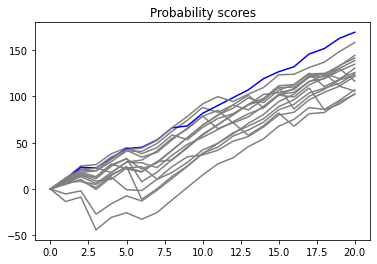

In [22]:
prob_score(0, correct_key, 20, mean_four, variances_four, traces_array_original);

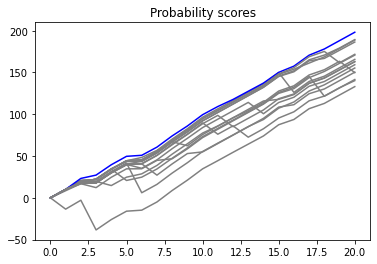

In [23]:
prob_score(1, correct_key, 20, mean_hw, variances_hw, traces_array_original);

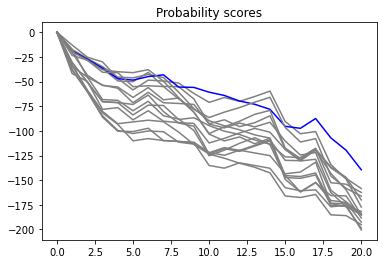

In [24]:
prob_score(0, correct_key, 20, mean_encoded[0], variances_encoded[0], traces_protected[0]);

In [25]:
#indices of traces/plaintexts used for computing success rate and guessing entropy
#generate random indices for traces in the attack set
no_of_attack = 100#number of attacks to do for computing GE
max_trace = int(file_no_protected/no_of_attack) #maximum number of traces to consider
indall = [[] for i in range(max_trace+1)]
def set_up_indices():
    for no_of_traces in range(max_trace+1):
        indall[no_of_traces] = random.sample(range(file_no_original), no_of_traces*no_of_attack)
    return
set_up_indices()

In [26]:
#Computing success rate and guessing entropy given the number of traces
def sr_ge_dpa(mean_vector, variances, no_of_traces, leakage_model, key_nibble, all_traces):
    ranks = []#store key rank in each simulated attack
    success_rate = 0
    
    for i in range(no_of_attack):#repeat no_of_attack attacks
        ind = indall[no_of_traces][i*no_of_traces:(i+1)*no_of_traces]
        traces = all_traces[ind]#leakges at POIs
        pts = plaintext[ind]#corresponding plaintext nibbles
        rk = compute_rank(template_prob_score(leakage_model, no_of_traces, traces, mean_vector, variances, pts),key_nibble)
        ranks.append(rk)
        if(rk == 1):
            success_rate += 1
    success_rate = success_rate/no_of_attack
    return success_rate, statistics.mean(ranks)

In [31]:
#compute sucess rate and guessing entropy for different number of traces
def get_SR_GE(key_nibble):
    SR_id = [0,0]
    GE_id = [0,0]
    SR_hw = [0,0]
    GE_hw = [0,0]
    
    SR_protected = [[0,0] for j in range(total_different_hw)]
    GE_protected = [[0,0] for j in range(total_different_hw)]
    
    for no_of_traces in range(2,max_trace+1):
        if no_of_traces%100 == 0:
            print('computing for number of traces ' + str(no_of_traces))
        #signal = v, original
        sr_id,ge_id = sr_ge_dpa(mean_four, variances_four, no_of_traces, 0, key_nibble, traces_array_original)
        SR_id.append(sr_id)
        GE_id.append(ge_id)
        #signal = Hamming weight 
        sr_hw,ge_hw = sr_ge_dpa(mean_hw, variances_hw, no_of_traces, 1, key_nibble, traces_array_original)
        SR_hw.append(sr_hw)
        GE_hw.append(ge_hw)
        
        #signal = v, protected
        for hw in range(total_different_hw):
            if hw == 1:
                continue
            sr_p,ge_p = sr_ge_dpa(mean_encoded[hw], variances_encoded[hw], no_of_traces, 0, key_nibble, traces_protected[hw])
            SR_protected[hw].append(sr_p)
            GE_protected[hw].append(ge_p)
    
    # Placing the plots in the plane
    plt.figure(figsize=(10,6)) 
    
    ##plot success rates
    ax1 = plt.subplot(3, 1, 1)
    plt.plot(SR_id, 'b')
    plt.plot(SR_hw, 'g')
    for hw in range(total_different_hw):
        if hw == 1:
            continue
        if hw == 0:
            plt.plot(SR_protected[hw], 'r')
        else:
            plt.plot(SR_protected[hw], 'k')
        
    ##plot guessing entropy
    ax2 = plt.subplot(3, 1, 2)
    plt.plot(GE_id, 'b')
    plt.plot(GE_hw, 'g')
    for hw in range(total_different_hw):
        if hw == 1:
            continue
        plt.plot(GE_protected[hw], 'k')
    
    ax1.set_title("SR")
    ax2.set_title("GE")
    
    
    ##save to file
    savetofile("SCA_countermeasure/SR",SR_id,0)
    savetofile("SCA_countermeasure/SR_hw",SR_hw,0)
    savetofile("SCA_countermeasure/GE",GE_id,0)
    savetofile("SCA_countermeasure/GE_hw",GE_hw,0)
    
    
    for hw in range(total_different_hw):
        if hw == 1:
            continue
        savetofile("SCA_countermeasure/SR_protected" + str(hw),SR_protected[hw],0)
        savetofile("SCA_countermeasure/GE_protected" + str(hw),GE_protected[hw],0)

    
    return SR_id, SR_hw, GE_id, GE_hw

computing for number of traces 100
computing for number of traces 200
computing for number of traces 300
computing for number of traces 400
computing for number of traces 500
computing for number of traces 600
computing for number of traces 700
computing for number of traces 800
computing for number of traces 900
computing for number of traces 1000


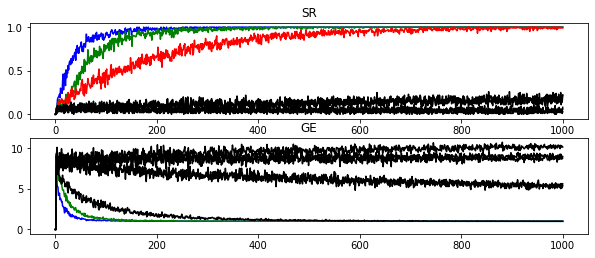

In [32]:
get_SR_GE(9);

In [15]:
a = [-0.010546242920711974, -0.009425586942538594, -0.006801814683860233, -0.007723589085820896, -0.006981878477742448, -0.007784893992932862, -0.006560954147640792, -0.007484447900466563, -0.00676639899380805, -0.007637893097310127, -0.006406679258241758, -0.00732269287109375, -0.00648602911237785, -0.007317254358161648, -0.0061911258971291865, -0.007159846844059406]

In [24]:
for i in range(16):
    print("%.5f, " % a[i], end="")

-0.01055, -0.00943, -0.00680, -0.00772, -0.00698, -0.00778, -0.00656, -0.00748, -0.00677, -0.00764, -0.00641, -0.00732, -0.00649, -0.00732, -0.00619, -0.00716, 

In [16]:
print(np.var(a))

1.2067495548853504e-06


In [19]:
b = [-0.010635400158478605, -0.010541945977917981, -0.010363222947761194, -0.010371440831987076, -0.010323194908180301, -0.010580948208722742, -0.010383642814009662, -0.010310832307060756, -0.010232744783306581, -0.010265003551136364, -0.010358647969242902, -0.010335950244698206, -0.0102051580400982, -0.010080989177067083, -0.010138973482008996, -0.009981787186028258]
print(np.var(b))

2.8458962896934257e-08


In [25]:
for i in range(16):
    print("%.5f," % b[i], end="")

-0.01064,-0.01054,-0.01036,-0.01037,-0.01032,-0.01058,-0.01038,-0.01031,-0.01023,-0.01027,-0.01036,-0.01034,-0.01021,-0.01008,-0.01014,-0.00998,